# Reanalyze the data from the Kosinski study
Eva Aßmann<br>
Paul Vogler

https://www.michalkosinski.com/data-mining-tutorial



# Imports

In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# Hands-On: Sample Big Data Set

In [0]:
users = pd.read_csv('/content/drive/My Drive/sample_dataset/users.csv')
likes = pd.read_csv('/content/drive/My Drive/sample_dataset/likes.csv')
userlikes = pd.read_csv('/content/drive/My Drive/sample_dataset/users-likes.csv')

## users

In [0]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110728 entries, 0 to 110727
Data columns (total 9 columns):
userid       110728 non-null object
gender       110728 non-null int64
age          110728 non-null int64
political    27808 non-null float64
ope          110728 non-null float64
con          110728 non-null float64
ext          110728 non-null float64
agr          110728 non-null float64
neu          110728 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 7.6+ MB


In [0]:
users[['age','ope','con','ext','agr','neu']].describe()

,age,ope,con,ext,agr,neu
count,110728.000000,110728.000000,110728.000000,110728.00000,110728.000000,110728.000000
mean,29.710534,0.028386,-0.005419,-0.01115,0.000883,0.006901
std,7.919357,0.993904,0.998988,1.00165,0.999586,1.003009
min,18.000000,-5.490000,-3.670000,-3.08000,-4.340000,-2.130000
25%,25.000000,-0.590000,-0.720000,-0.71000,-0.590000,-0.760000
50%,27.000000,0.150000,0.020000,0.11000,0.070000,-0.070000
75%,32.000000,0.790000,0.690000,0.73000,0.740000,0.740000
max,80.000000,1.900000,2.240000,1.92000,2.320000,2.850000


In [0]:
for elem in ['gender','political']:
  print(elem)
  print(users[elem].unique())
  print('\n')

gender
[0 1]


political
[ 0. nan  1.]




__impute missing political views with -1__

In [0]:
110728-27808

82920

__ IMPUTATION NOT NECESSARY SINCE PD.CORR() LATER IGNORES NAN CASES__

In [0]:
#users.political[users.political.isnull()] = -1

## likes

In [0]:
likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580284 entries, 0 to 1580283
Data columns (total 2 columns):
likeid    1580284 non-null object
name      1580276 non-null object
dtypes: object(2)
memory usage: 24.1+ MB


In [0]:
likes.head()

,likeid,name
0,3c1636c878e6eb2acfd00c6b61086e38,REIGN by Paul Gibson
1,feca46ddb8ef04f86172ace0cb7e004c,Cupcake Wishes & Birthday Dreams
2,b65f46d64c688fe98bdbcf93a76a71fc,Yo también me rei de la caída de otro jejeje
3,9c5c8bb82d2cd46fbd7582f944fe370e,Abraham Joshua Heschel Day School- Alumni Network
4,2d82fa84ad79b085dc516dde154327a2,Kennesaw Farmer's Market


In [0]:
likes[likes.name.isnull()]

,likeid,name
242345,f89e13f3e5acf2571250abea5258ee8b,NaN
243573,3565c7dc1d7eca1a1da2a55482710be3,NaN
249147,9757cd2f84bbf001e0ecd00941a44741,NaN
287307,c40d6dbce31b3aa668ba19e56bed8c1f,NaN
337312,030f177a989efd046bb88e6ffa4d2787,NaN
367556,ce13cdee7bf5e8296f970228d7f36602,NaN
474264,5746a300bdd53c1250c713e5d5c1b7fd,NaN
1541386,96375224bcf657249970ac048af00f79,NaN


__Impute missing names with 'no data'__

In [0]:
likes.name[likes.name.isnull()] = 'no data'

## users-like

In [0]:
userlikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10612326 entries, 0 to 10612325
Data columns (total 2 columns):
userid    object
likeid    object
dtypes: object(2)
memory usage: 161.9+ MB


In [0]:
userlikes.head()

,userid,likeid
0,71bc7c0901488aec6d30f0add257e7c5,3c1636c878e6eb2acfd00c6b61086e38
1,978ab8e90c4d6ad1a48ef5c973b62f4d,feca46ddb8ef04f86172ace0cb7e004c
2,85123b0e358907725cf19a2cb0ec3983,b65f46d64c688fe98bdbcf93a76a71fc
3,ce110562b3e2f7e5cad3775b32d9caa5,b65f46d64c688fe98bdbcf93a76a71fc
4,8188d20745471273fa69ba44a5b28473,b65f46d64c688fe98bdbcf93a76a71fc


In [0]:
users.shape[0] == userlikes.userid.unique().shape[0]

True

In [0]:
likes.shape[0] == userlikes.likeid.unique().shape[0]

True

# Hands-On: Constructing a User-Like Matrix
https://www.rdocumentation.org/packages/Matrix/versions/1.2-18/topics/sparseMatrix 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix



__Match entries in userlikes with IDs in users and likes__<br>
Matched user and like ID indices will be row and column indices for user-like-relationship in sparse matrix)

In [0]:
# FIRST APPROACH WAS TOO SLOW
#match = lambda a, b: [ np.where(b == x)[0].item(0) if x in b else None for x in a ]
#test = [match(userlikes.userid.values, users.userid.values)[0]]

started 10:48

In [0]:
#SECOND APPROACH WAS TOO SLOW
#def match(a,b):
#  for i in range(b.shape[0]):
#    if b[i] == a:
#      return i
#test = []
#for x in userlikes.userid.values:
#  test.append(match(x,users.userid.values))

interrupt at 11:30:

len(test) = 442001

that is 4% of the size of the userlike object....



In [0]:
#test2 = []
#for x in userlikes.likeid.values:
#  test2.append(match(x,likes.likeid.values))

In [0]:
# THIRD APPROACH FOR MATCHING INDICES WAS SLOWER THAN THE FIRST ONE
#matched_userid = []
#for elem in userlikes.userid.values:
#  x = users.userid[users.userid==elem].index[0]
#  matched_userid.append(x)

In [0]:
#matched_likeid = []
#for elem in userlikes.likeid.values
#  x = likes.likeid[likes.likeid==elem].index[0] 
#  matched_likeid.append(x)

In [0]:
users['idx']=users.index

In [0]:
users.head()

,userid,gender,age,political,ope,con,ext,agr,neu,idx
0,54f34605aebd63f7680e37ffd299af79,0,33,0.0,1.26,1.65,1.17,-1.76,0.61,0
1,86399f8c44ba54224b2e60177ca89fa9,1,35,0.0,1.07,0.17,-0.14,1.49,0.30,1
2,84fab50f3c60d1fdc83aa91b5e584a78,1,36,0.0,0.89,1.28,0.86,1.07,0.99,2
3,f3b8fdaccce12ef6352bfad4d6052fe9,0,39,NaN,0.33,-1.01,-0.33,-0.68,0.92,3
4,8b06ea5e9cb87c61da387995450607f7,0,31,NaN,0.15,0.47,1.17,-1.01,-0.32,4


In [0]:
matched_users = userlikes.userid.map(users.set_index('userid').idx)

In [0]:
len(matched_users)

10612326

In [0]:
likes['idx'] = likes.index

In [0]:
matched_likes = userlikes.likeid.map(likes.set_index('likeid').idx)

In [0]:
len(matched_likes)

10612326

__Build user-footprint matrix__<br>
for each user store count 1 for every Fb post/video/picture/etc. he or she liked in a sparsed matrix (because many more variables than users and there will be variables/users with quite a lot of zero entries)

In [0]:
# THIS APPROACH REQUIRES TOO MUCH MEMORY AND MADE SESION CRASH

#M = np.zeros((users.shape[0], likes.shape[0]))
#uid = users.userid.values
# for every user get all liked Fb entities
#for i in range(users.shape[0]):
#  tmp = userlikes[userlikes.userid==uid[i]]
#  # for every liked Fb entity: if liked by user store 1, else store 0
#  for l in tmp.likeid.values:
#    j = likes[likes.likeid==l].index.values.item(0)
#    S[i,j] = 1

#M_sparse = coo_matrix(M)

In [0]:
m = np.array(matched_users)
n = np.array(matched_likes)
data = np.array([1]*userlikes.shape[0])
coo = coo_matrix((data, (m,n)), shape=(users.shape[0], likes.shape[0]))

__Descriptive Statistics__

In [0]:
coo.get_shape()

(110728, 1580284)

In [0]:
coo.getnnz()

10612326

In [0]:
# Matrix density = number of non-zero entries / size of matrix
10612326/np.float(110728*1580284)

6.064820951829522e-05

In [0]:
# Users per like
L = coo.sum(axis=0).A
np.min(L), np.max(L), np.mean(L), np.median(L)

(1, 19998, 6.715454943541793, 1.0)

In [0]:
# Likes per user
U  = coo.sum(axis=1).A
np.min(U), np.max(U), np.mean(U), np.median(U)

(1, 7973, 95.84139513040965, 22.0)

# Hands-On: Trimming the User-Like Matrix
Remove users and footprints that are below the respective minimum frequency threshold C:

C(Users) = 50

C(footprint) = 150


In [0]:
csr = csr_matrix(coo)

In [0]:
csr_trim = csr
userscopy = users.drop('idx',axis=1)

In [0]:
x = 0
y = 1
while x != y:
  x = sum(csr_trim.get_shape())
  U = csr_trim.sum(axis=1)
  L = csr_trim.sum(axis=0)
  removeusers = np.where(U>=50)[0]
  # remove users from users object
  tmp = np.where(U<50)[0]
  userscopy = userscopy.drop(index=tmp, axis=0).reset_index(drop=True)
  removelikes = np.where(L>=150)[1]
  # remove users from User-Like matrix
  csr_trim = csr_trim[removeusers,:]
  #remove likes from User-Like matix
  csr_trim = csr_trim[:,removelikes]
  # update sum of dimensions
  y = sum(csr_trim.get_shape())

__Descriptive Statistics__

In [0]:
csr_trim.get_shape()

(19742, 8523)

In [0]:
csr_trim.getnnz()

3817840

In [0]:
# Matrix density
3817840/np.float(19742*8523)

0.022689978678727733

In [0]:
# Users per like
L = csr_trim.sum(axis=0).A
np.min(L), np.max(L), np.mean(L), np.median(L)

(150, 8445, 447.94555907544293, 290.0)

In [0]:
# Likes per user
U = csr_trim.sum(axis=1).A
np.min(U), np.max(U), np.mean(U), np.median(U)

(50, 2487, 193.38668827879647, 106.0)

# Hands-On: Reducing the Dimensionality of the User-Like Matrix Using SVD and LDA

## LDA

__Look at log-likelihood of the fitted model for different numbers of topics k__

In [0]:
seed = 68
alpha = 10
delta = 0.1

In [0]:
lg = []
for k in range(2,7,1):
  lda = LatentDirichletAllocation(n_components=k, random_state=seed, doc_topic_prior=alpha, topic_word_prior=delta)
  lda.fit(csr_trim)
  lg.append(lda.score(csr_trim))


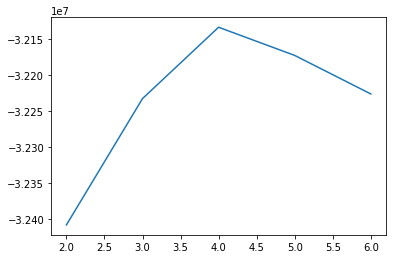

In [0]:
plt.plot(range(2,7),lg)

__Perform LDA with parameter settings from Kosinski paper__

In [0]:
k_kosinski = 5
lda = LatentDirichletAllocation(n_components=k_kosinski, random_state=seed, doc_topic_prior=alpha, topic_word_prior=delta)

In [0]:
lda.fit(csr_trim)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=10, evaluate_every=-1,
                          learning_decay=0.7, learning_method='batch',
                          learning_offset=10.0, max_doc_update_iter=100,
                          max_iter=10, mean_change_tol=0.001, n_components=5,
                          n_jobs=None, perp_tol=0.1, random_state=68,
                          topic_word_prior=0.1, total_samples=1000000.0,
                          verbose=0)

In [0]:
# get log-likelihood of the model
lda.score(csr_trim)

-32172913.862576805

In [0]:
X = lda.transform(csr_trim)

In [0]:
X.shape

(19742, 5)

In [0]:
X[:10,:]

array([[0.117135  , 0.11760453, 0.50607297, 0.15867398, 0.10051352],
       [0.13104847, 0.1208406 , 0.34029965, 0.3090692 , 0.09874208],
       [0.21163727, 0.12836589, 0.26093792, 0.32244258, 0.07661634],
       [0.19460897, 0.08475805, 0.40351513, 0.25884564, 0.05827221],
       [0.11961076, 0.1169092 , 0.24832052, 0.41527467, 0.09988485],
       [0.13744016, 0.12221499, 0.11311782, 0.5351601 , 0.09206693],
       [0.10307004, 0.10382989, 0.11956902, 0.58537771, 0.08815335],
       [0.08346499, 0.07457899, 0.07811625, 0.69746346, 0.06637631],
       [0.14519788, 0.11332814, 0.3705406 , 0.29698684, 0.07394653],
       [0.12638206, 0.12820065, 0.30076538, 0.35993769, 0.08471422]])

## SVD

# Hands-On: Interpreting Clusters and Dimensions

## LDA

Pearson correlation between topics and users psychodemograhpic information: pairwise deletion, meaning ignoring nan entries

In [0]:
X_df = pd.DataFrame(data=X,columns=range(1,6))

In [0]:
userscopy.shape

(19742, 9)

In [0]:
X_df = pd.concat([X_df, userscopy[['gender', 'age', 'political', 'ope', 'con', 'ext', 'agr','neu']]], axis=1)

In [0]:
corr = X_df.corr().iloc[5:,:5]

In [0]:
corr

,1,2,3,4,5
gender,0.107990,0.047306,-0.125888,-0.135848,0.113160
age,0.109071,-0.182050,0.254510,0.117541,-0.261499
political,0.090987,0.174307,-0.126981,-0.119108,0.072591
ope,-0.162607,-0.109280,0.174087,0.172957,-0.115234
con,0.125943,-0.010253,0.002775,0.008250,-0.081482
ext,0.086093,-0.009360,-0.002054,-0.067141,0.007532
agr,0.051300,0.034413,0.014024,-0.023305,-0.039312
neu,-0.043497,0.016090,-0.051138,0.001585,0.055119


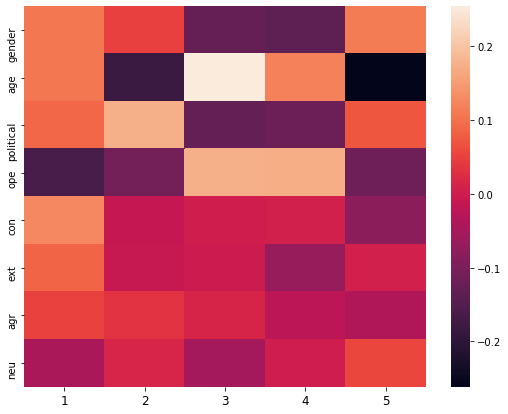

In [0]:
plt.figure(figsize=(9,7))
sns.heatmap(corr, xticklabels=range(1,6), yticklabels=corr.index)
plt.xticks(fontsize=12)
plt.show()

## SVD

# Predicting Real-Life Outcomes with Facebook Likes